# SWRL Rule to DOT Graph Converter

This notebook converts SWRL (Semantic Web Rule Language) rules into DOT graph format for visualization.

In [82]:
# create your Virtual Environment and pip install the required packages:
#%pip install graphviz

In [83]:
# Insert your SWRL rule here
swrl_rule = """bot:Building(?b) ^ fisa:hasBuildingClass(?b, ?bcl) ^ fisa:BuildingClass5(?bcl) ^ bot:containsZone(?b, ?nss) ^ fisa:NecessaryStairSpace(?nss) ^ fisa:Wall(?w) ^ fisa:isSpaceEnclosing(?w, true) ^ bot:adjacentElement(?nss, ?w) -> fisa:hasRequirementOfFireResistance(?w, fisa:feuerbeständig) ^ fisa:WallOfANecessaryStaircase(?w) ^ fisa:hasAssessmentBasis(?w, fisa:MBO_P35_A4_S1_P1)"""

In [84]:
import re
from typing import Dict, List, Tuple, Set

## SWRL Parser and DOT Generator

In [85]:
class SWRLToDOT:
    """Convert SWRL rules to DOT graph format"""
    
    def __init__(self):
        self.variables = set()
        self.classes = {}  # variable -> class
        self.properties = []  # (subject, predicate, object)
        self.atoms = []
        
    def parse_swrl_rule(self, rule: str) -> Tuple[List[str], List[str]]:
        """Parse SWRL rule into antecedent and consequent atoms"""
        # Split by arrow
        parts = rule.split('->')
        if len(parts) != 2:
            raise ValueError("Invalid SWRL rule: missing '->' separator")
        
        antecedent = parts[0].strip()
        consequent = parts[1].strip()
        
        # Parse atoms (separated by ^)
        antecedent_atoms = [atom.strip() for atom in re.split(r'\s*\^\s*', antecedent)]
        consequent_atoms = [atom.strip() for atom in re.split(r'\s*\^\s*', consequent)]
        
        return antecedent_atoms, consequent_atoms
    
    def parse_atom(self, atom: str) -> Dict:
        """Parse a single SWRL atom"""
        # Pattern for class atoms: prefix:ClassName(?var)
        class_pattern = r'(\w+):(\w+)\((\?\w+)\)'
        # Pattern for property atoms: prefix:propertyName(?var1, ?var2) or (?var1, literal)
        property_pattern = r'(\w+):(\w+)\((\?\w+),\s*(.+?)\)'
        
        class_match = re.match(class_pattern, atom)
        if class_match:
            prefix, class_name, variable = class_match.groups()
            return {
                'type': 'class',
                'prefix': prefix,
                'class': class_name,
                'variable': variable
            }
        
        property_match = re.match(property_pattern, atom)
        if property_match:
            prefix, property_name, subject, obj = property_match.groups()
            obj = obj.strip()
            return {
                'type': 'property',
                'prefix': prefix,
                'property': property_name,
                'subject': subject,
                'object': obj
            }
        
        raise ValueError(f"Cannot parse atom: {atom}")
    
    def generate_dot(self, rule: str, output_file: str = None) -> str:
        """Generate DOT graph from SWRL rule"""
        # Reset state
        self.variables = set()
        self.classes = {}
        self.properties = []
        
        # Parse rule
        antecedent_atoms, consequent_atoms = self.parse_swrl_rule(rule)
        
        # Process all atoms
        all_atoms = []
        for atom in antecedent_atoms:
            parsed = self.parse_atom(atom)
            parsed['part'] = 'antecedent'
            all_atoms.append(parsed)
            
        for atom in consequent_atoms:
            parsed = self.parse_atom(atom)
            parsed['part'] = 'consequent'
            all_atoms.append(parsed)
        
        # Extract variables, classes, and properties
        for atom in all_atoms:
            if atom['type'] == 'class':
                var = atom['variable']
                self.variables.add(var)
                if var not in self.classes:
                    self.classes[var] = []
                self.classes[var].append({
                    'class': f"{atom['prefix']}:{atom['class']}",
                    'part': atom['part']
                })
            elif atom['type'] == 'property':
                subject = atom['subject']
                obj = atom['object']
                self.variables.add(subject)
                if obj.startswith('?'):
                    self.variables.add(obj)
                self.properties.append({
                    'subject': subject,
                    'predicate': f"{atom['prefix']}:{atom['property']}",
                    'object': obj,
                    'part': atom['part']
                })
        
        # Generate DOT
        dot = self._create_dot_graph()
        
        # Save to file if specified
        if output_file:
            with open(output_file, 'w') as f:
                f.write(dot)
            print(f"DOT file saved to: {output_file}")
        
        return dot
    
    def _create_dot_graph(self) -> str:
        """Create DOT graph representation"""
        lines = []
        lines.append('digraph SWRL_Rule {')
        # lines.append('    rankdir=TD;')
        lines.append('    rankdir=LR;')
        lines.append('    node [shape=box, style=rounded];')
        lines.append('')
        
        # Collect all unique classes
        all_classes = set()
        for var, class_list in self.classes.items():
            for cls_info in class_list:
                all_classes.add(cls_info['class'])
        
        # Add class nodes
        lines.append('    // Classes')
        for cls in sorted(all_classes):
            lines.append(f'    "{cls}" [shape=ellipse, fillcolor=lightgreen, style=filled];')
        
        lines.append('')
        
        # Add variables as nodes (without class labels)
        lines.append('    // Variables (Instances)')
        for var in sorted(self.variables):
            lines.append(f'    "{var}" [label="{var}", fillcolor=lightblue, style="rounded,filled"];')
        
        lines.append('')
        
        # Add literal nodes for non-variable objects
        lines.append('    // Literals')
        literals = set()
        for prop in self.properties:
            obj = prop['object']
            if not obj.startswith('?'):
                literals.add(obj)
        
        for literal in sorted(literals):
            lines.append(f'    "{literal}" [shape=box, style=filled, fillcolor=lightyellow];')
        
        lines.append('')
        
        # Add class-to-instance edges (type relationships)
        lines.append('    // Class Assertions (rdf:type)')
        for var in sorted(self.variables):
            if var in self.classes:
                for cls_info in self.classes[var]:
                    cls = cls_info['class']
                    part = cls_info['part']
                    # Style edges differently for consequent
                    if part == 'consequent':
                        lines.append(f'    "{cls}" -> "{var}" [label="rdf:type", color=blue, penwidth=2, style=dashed];')
                    else:
                        lines.append(f'    "{cls}" -> "{var}" [label="rdf:type", style=dashed];')
        
        lines.append('')
        
        # Add properties as edges
        lines.append('    // Properties')
        for prop in self.properties:
            subject = prop['subject']
            predicate = prop['predicate']
            obj = prop['object']
            part = prop['part']
            
            # Style edges differently for consequent
            if part == 'consequent':
                lines.append(f'    "{subject}" -> "{obj}" [label="{predicate}", color=blue, penwidth=2];')
            else:
                lines.append(f'    "{subject}" -> "{obj}" [label="{predicate}"];')
        
        lines.append('}')
        
        return '\n'.join(lines)

## Example Usage

In [106]:
# Example SWRL Rule
swrl_rule = """fisa:FireCompartment(?c1) ^ fisa:FireCompartment(?c2) ^ bot:adjacentZone(?c1, ?c2) ^ fisa:Wall(?w) ^ bot:Space(?s1) ^ bot:Space(?s2) ^ bot:containsZone(?c1, ?s1) ^ bot:containsZone(?c2, ?s2) ^ bot:adjacentElement(?s1, ?w) ^ bot:adjacentElement(?s2, ?w) -> fisa:InternalFireWall(?w) ^ fisa:hasAssessmentBasis(?w, fisa:MBO_P30_A1_S1_P2)"""
# swrl_rule = """bot:Building(?b) ^ bot:hasStorey(?b, ?st) ^ fisa:hasUtilizationSpace(?st, ?uu) ^ bot:adjacentZone(?uu, ?auu) ^ bot:hasElement(?st, ?cw) ^ fisa:CompartmentWall(?cw) ^ bot:interfaceOf(?cw, ?if) ^ bot:interfaceOf(?auu, ?if) ^ bot:hasElement(?st, ?w) ^ fisa:Wall(?w) ^ fisa:isLoadBearing(?w, true) ^ fisa:hasFireResistance(?w, ?frw) ^ fisa:isMoreFireResistantThan(?frw, fisa:feuerhemmend) -> fisa:hasRequirementOfFireResistance(?cw, ?frw) ^ fisa:hasAssessmentBasis(?cw, fisa:MBO_P29_A3_S1_P1)"""
swrl_rule = """bot:Building(?b) ^ fisa:hasBuildingClass(?b, ?bcl) ^ fisa:BuildingClass5(?bcl) ^ bot:containsZone(?b, ?nss) ^ fisa:NecessaryStairSpace(?nss) ^ fisa:Wall(?w) ^ fisa:isSpaceEnclosing(?w, true) ^ bot:adjacentElement(?nss, ?w) -> fisa:hasRequirementOfFireResistance(?w, fisa:feuerbeständig) ^ fisa:WallOfANecessaryStaircase(?w) ^ fisa:hasAssessmentBasis(?w, fisa:MBO_P35_A4_S1_P1)"""
swrl_rule = """bot:Building(?b) ^ bot:containsZone(?b, ?fc1) ^ fisa:FireCompartment(?fc1) ^ bot:containsZone(?b, ?fc2) ^ fisa:FireCompartment(?fc2) ^ fisa:Wall(?w) ^ bot:containsElement(?b, ?w) ^ fisa:isSpaceEnclosing(?w, true) ^ bot:adjacentElement(?fc1, ?w) ^ bot:adjacentElement(?fc2, ?w) -> fisa:InternalFireWall(?w) ^ fisa:hasAssessmentBasis(?w, fisa:MBO_P30_A1_2)"""
swrl_rule = """bot:Building(?b) ^ bot:hasElement(?b, ?ew) ^ fisa:ExternalWall(?ew) ^ fisa:hasDistanceToBoundary(?ew, ?d) ^ swrlb:lessThan(?d, 2.5) -> fisa:FireWallAsExternalWall(?ew) ^ fisa:hasRequirementOfFireResistance(?ew, fisa:feuerbeständig) ^ fisa:hasRequirementOfFireBehaviour(?ew, fisa:nichtbrennbar) ^ fisa:hasAssessmentBasis(?ew, fisa:MBO_P30_A2_N1)"""
swrl_rule = """bot:Building(?b) ^ bot:hasElement(?b, ?ew) ^ fisa:ExternalWall(?ew) ^ fisa:hasDistanceToBoundary(?ew, 0.0) -> fisa:FireWallAsExternalWall(?ew) ^ fisa:hasRequirementOfFireResistance(?ew, fisa:feuerbeständig) ^ fisa:hasRequirementOfFireBehaviour(?ew, fisa:nichtbrennbar) ^ fisa:hasAssessmentBasis(?ew, fisa:MBO_P30_A2_N1_A)"""

# Create converter
converter = SWRLToDOT()

# Generate DOT file
dot_content = converter.generate_dot(swrl_rule, output_file='swrl_rule_graph.dot')

# Display the DOT content
print("Generated DOT Graph:")
print("="*60)
print(dot_content)

DOT file saved to: swrl_rule_graph.dot
Generated DOT Graph:
digraph SWRL_Rule {
    rankdir=LR;
    node [shape=box, style=rounded];

    // Classes
    "bot:Building" [shape=ellipse, fillcolor=lightgreen, style=filled];
    "fisa:ExternalWall" [shape=ellipse, fillcolor=lightgreen, style=filled];
    "fisa:FireWallAsExternalWall" [shape=ellipse, fillcolor=lightgreen, style=filled];

    // Variables (Instances)
    "?b" [label="?b", fillcolor=lightblue, style="rounded,filled"];
    "?ew" [label="?ew", fillcolor=lightblue, style="rounded,filled"];

    // Literals
    "0.0" [shape=box, style=filled, fillcolor=lightyellow];
    "fisa:MBO_P30_A2_N1_A" [shape=box, style=filled, fillcolor=lightyellow];
    "fisa:feuerbeständig" [shape=box, style=filled, fillcolor=lightyellow];
    "fisa:nichtbrennbar" [shape=box, style=filled, fillcolor=lightyellow];

    // Class Assertions (rdf:type)
    "bot:Building" -> "?b" [label="rdf:type", style=dashed];
    "fisa:ExternalWall" -> "?ew" [label="rdf:

## Visualize with Graphviz

Graph rendered to swrl_rule_graph.pdf
Graph visualization:


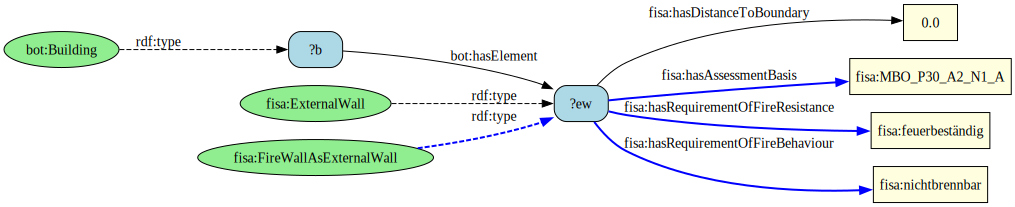

In [107]:
try:
    import graphviz
    from IPython.display import display
    
    # Create graph from DOT source
    graph = graphviz.Source(dot_content)
    
    # Render to PDF file for external use
    graph.render('swrl_rule_graph', format='pdf', cleanup=True)
    print("Graph rendered to swrl_rule_graph.pdf")
    print("="*60)
    
    # Display in notebook as SVG (inline visualization)
    print("Graph visualization:")
    display(graph)
    
except ImportError:
    print("Graphviz not installed. Install with: pip install graphviz")

## Function to Convert Any SWRL Rule

In [103]:
def swrl_to_dot(swrl_rule: str, output_file: str = 'output.dot') -> str:
    """
    Convert a SWRL rule to DOT format and save to file.
    
    Parameters:
    -----------
    swrl_rule : str
        The SWRL rule string
    output_file : str
        Output file path for the DOT file (default: 'output.dot')
    
    Returns:
    --------
    str : The DOT graph content
    
    Example:
    --------
    rule = "fisa:FireCompartment(?c1) ^ bot:adjacentZone(?c1, ?c2) -> fisa:InternalWall(?w)"
    dot = swrl_to_dot(rule, 'my_rule.dot')
    """
    converter = SWRLToDOT()
    return converter.generate_dot(swrl_rule, output_file)

# Test with your custom rule
print("Ready to convert SWRL rules to DOT format!")
print("Use: swrl_to_dot(your_rule, 'output.dot')")

Ready to convert SWRL rules to DOT format!
Use: swrl_to_dot(your_rule, 'output.dot')


In [111]:
def swrl_to_pdf(swrl_rule: str, output_pdf: str = 'output.pdf') -> None:
    """
    Convert a SWRL rule to a PDF graph using DOT format.
    
    Parameters:
    -----------
    swrl_rule : str
        The SWRL rule string
    output_pdf : str
        Output file path for the PDF file (default: 'output.pdf')
    
    Example:
    --------
    rule = "fisa:FireCompartment(?c1) ^ bot:adjacentZone(?c1, ?c2) -> fisa:InternalWall(?w)"
    swrl_to_pdf(rule, 'my_rule.pdf')
    """
    dot_content = swrl_to_dot(swrl_rule, output_file=None)
    
    try:
        import graphviz
        
        # Create graph from DOT source
        graph = graphviz.Source(dot_content)
        
        # Render to PDF file
        graph.render(output_pdf.replace('.pdf', ''), format='pdf', cleanup=True)
        print(f"Graph rendered to {output_pdf}")

        display(graph)
        
    except ImportError:
        print("Graphviz not installed. Install with: pip install graphviz")

Graph rendered to swrl_rule_graph.pdf


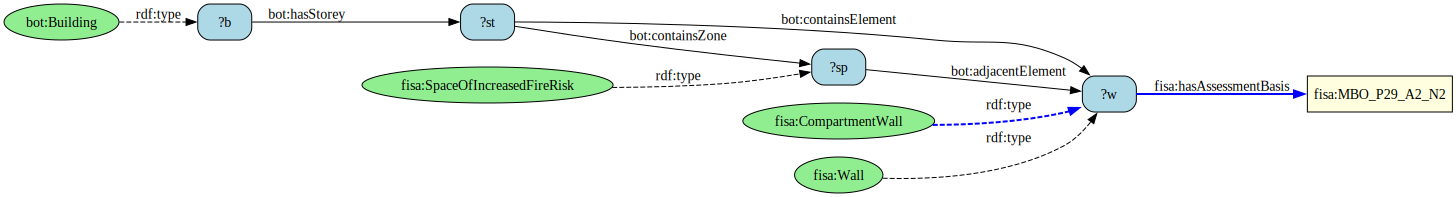

In [112]:
swrl_to_pdf("""bot:Building(?b) ^ bot:hasStorey(?b, ?st) ^ bot:containsZone(?st, ?sp) ^ fisa:SpaceOfIncreasedFireRisk(?sp) ^ bot:containsElement(?st, ?w) ^ fisa:Wall(?w) ^ bot:adjacentElement(?sp, ?w) -> fisa:CompartmentWall(?w) ^ fisa:hasAssessmentBasis(?w, fisa:MBO_P29_A2_N2)""", output_pdf='swrl_rule_graph.pdf')

Graph rendered to output.pdf


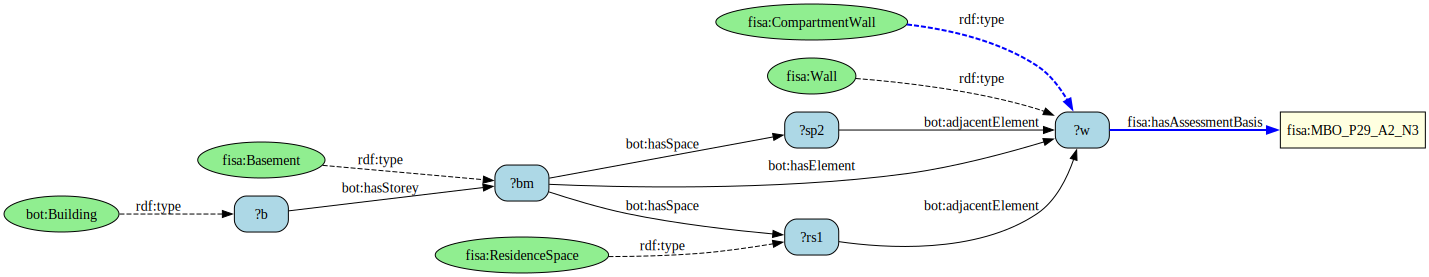

In [113]:
swrl_to_pdf("""bot:Building(?b) ^ bot:hasStorey(?b, ?bm) ^ fisa:Basement(?bm) ^ bot:hasSpace(?bm, ?rs1) ^ fisa:ResidenceSpace(?rs1) ^ bot:hasSpace(?bm, ?sp2) ^ bot:hasElement(?bm, ?w) ^ fisa:Wall(?w) ^ bot:adjacentElement(?rs1, ?w) ^ bot:adjacentElement(?sp2, ?w) -> fisa:CompartmentWall(?w) ^ fisa:hasAssessmentBasis(?w, fisa:MBO_P29_A2_N3)""")

Schema legend saved to: legend_schema.pdf


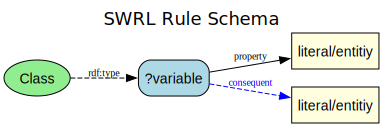

In [104]:
# Create Legend as small schema graph
def create_legend_schema(output_file='legend_schema.pdf'):
    """Create a compact schema-style legend showing SWRL rule structure"""
    schema_dot = '''
    digraph SWRL_Schema {
        rankdir=LR;
        node [fontname="Arial"];
        
        // Title
        label="SWRL Rule Schema";
        labelloc="t";
        fontsize=18;
        fontname="Arial Bold";
        
        // Define nodes
        "Class" [shape=ellipse, fillcolor=lightgreen, style=filled, label="Class"];
        "?instance" [shape=box, fillcolor=lightblue, style="rounded,filled", label="?variable"];
        "literal" [shape=box, fillcolor=lightyellow, style=filled, label="literal/entitiy"];
        "literal2" [shape=box, fillcolor=lightyellow, style=filled, label="literal/entitiy"];
        
        // Show relationships
        "Class" -> "?instance" [label="rdf:type", style=dashed, fontsize=10];
        "?instance" -> "literal" [label="property", fontsize=10];
        "?instance" -> "literal2" [label="consequent", style=dashed, color=blue, fontcolor=blue, fontsize=10];
    }
    '''
    
    try:
        import graphviz        
        # Create graph from DOT source
        schema_graph = graphviz.Source(schema_dot)
        
        # Render to PDF
        schema_graph.render(output_file.replace('.pdf', ''), format='pdf', cleanup=True)
        print(f"Schema legend saved to: {output_file}")
        
        return schema_graph
        
    except ImportError:
        print("Graphviz not installed. Install with: pip install graphviz")
        return None

# Create the schema legend
create_legend_schema('legend_schema.pdf')

Legend saved to: swrl_legend.pdf


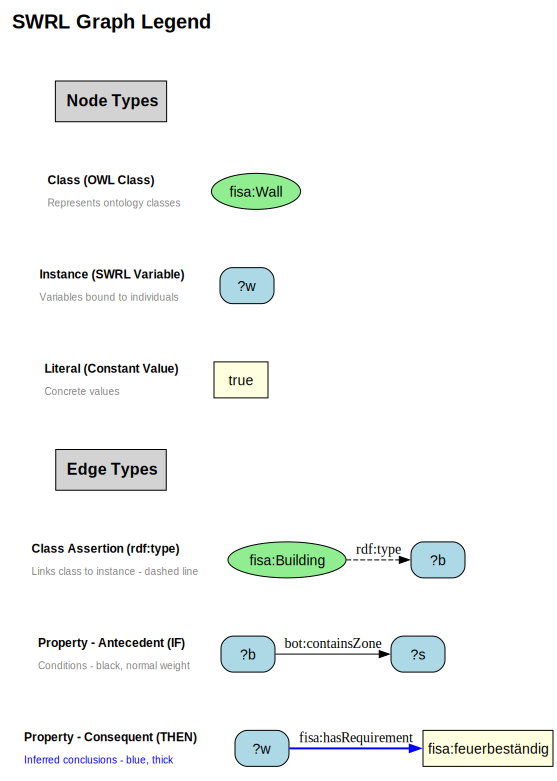

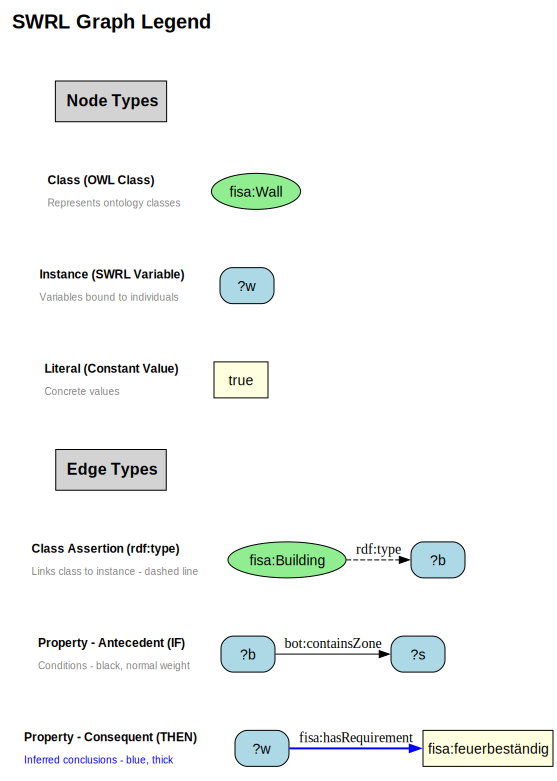

In [105]:
# Create Legend as PDF
def create_legend_pdf(output_file='legend.pdf'):
    """Create a standalone legend as a PDF file with visual examples"""
    legend_dot = '''
    digraph Legend {
        rankdir=TB;
        node [fontname="Arial"];
        ranksep=0.5;
        nodesep=0.3;
        
        // Title
        title [shape=plaintext, label=<<font point-size="20"><b>SWRL Graph Legend</b></font>>];
        
        // Node Types Section Header
        node_header [shape=plaintext, label=<<table border="1" cellborder="0" cellspacing="5" cellpadding="5" bgcolor="lightgrey">
            <tr><td><font point-size="16"><b>Node Types</b></font></td></tr>
        </table>>];
        
        // Class type
        class_section [shape=plaintext, label=<<table border="0" cellborder="0" cellspacing="5">
            <tr><td align="left"><font point-size="12"><b>Class (OWL Class)</b></font></td></tr>
            <tr><td align="left"><font point-size="10" color="gray">Represents ontology classes</font></td></tr>
        </table>>];
        class_example [shape=ellipse, fillcolor=lightgreen, style=filled, label="fisa:Wall"];
        
        // Instance type
        instance_section [shape=plaintext, label=<<table border="0" cellborder="0" cellspacing="5">
            <tr><td align="left"><font point-size="12"><b>Instance (SWRL Variable)</b></font></td></tr>
            <tr><td align="left"><font point-size="10" color="gray">Variables bound to individuals</font></td></tr>
        </table>>];
        instance_example [shape=box, fillcolor=lightblue, style="rounded,filled", label="?w"];
        
        // Literal type
        literal_section [shape=plaintext, label=<<table border="0" cellborder="0" cellspacing="5">
            <tr><td align="left"><font point-size="12"><b>Literal (Constant Value)</b></font></td></tr>
            <tr><td align="left"><font point-size="10" color="gray">Concrete values</font></td></tr>
        </table>>];
        literal_example [shape=box, fillcolor=lightyellow, style=filled, label="true"];
        
        // Edge Types Section Header
        edge_header [shape=plaintext, label=<<table border="1" cellborder="0" cellspacing="5" cellpadding="5" bgcolor="lightgrey">
            <tr><td><font point-size="16"><b>Edge Types</b></font></td></tr>
        </table>>];
        
        // Class assertion type
        assertion_section [shape=plaintext, label=<<table border="0" cellborder="0" cellspacing="5">
            <tr><td align="left"><font point-size="12"><b>Class Assertion (rdf:type)</b></font></td></tr>
            <tr><td align="left"><font point-size="10" color="gray">Links class to instance - dashed line</font></td></tr>
        </table>>];
        assertion_class [shape=ellipse, fillcolor=lightgreen, style=filled, label="fisa:Building"];
        assertion_instance [shape=box, fillcolor=lightblue, style="rounded,filled", label="?b"];
        
        // Antecedent property type
        antecedent_section [shape=plaintext, label=<<table border="0" cellborder="0" cellspacing="5">
            <tr><td align="left"><font point-size="12"><b>Property - Antecedent (IF)</b></font></td></tr>
            <tr><td align="left"><font point-size="10" color="gray">Conditions - black, normal weight</font></td></tr>
        </table>>];
        ant_var1 [shape=box, fillcolor=lightblue, style="rounded,filled", label="?b"];
        ant_var2 [shape=box, fillcolor=lightblue, style="rounded,filled", label="?s"];
        
        // Consequent property type
        consequent_section [shape=plaintext, label=<<table border="0" cellborder="0" cellspacing="5">
            <tr><td align="left"><font point-size="12"><b>Property - Consequent (THEN)</b></font></td></tr>
            <tr><td align="left"><font point-size="10" color="blue">Inferred conclusions - blue, thick</font></td></tr>
        </table>>];
        cons_var [shape=box, fillcolor=lightblue, style="rounded,filled", label="?w"];
        cons_literal [shape=box, fillcolor=lightyellow, style=filled, label="fisa:feuerbeständig"];
        
        // Vertical ordering with invisible edges
        title -> node_header [style=invis];
        node_header -> class_section [style=invis];
        class_section -> instance_section [style=invis];
        instance_section -> literal_section [style=invis];
        literal_section -> edge_header [style=invis];
        edge_header -> assertion_section [style=invis];
        assertion_section -> antecedent_section [style=invis];
        antecedent_section -> consequent_section [style=invis];
        
        // Example edges
        assertion_class -> assertion_instance [label="rdf:type", style=dashed];
        ant_var1 -> ant_var2 [label="bot:containsZone"];
        cons_var -> cons_literal [label="fisa:hasRequirement", color=blue, penwidth=2];
        
        // Horizontal alignment within sections
        {rank=same; class_section; class_example;}
        {rank=same; instance_section; instance_example;}
        {rank=same; literal_section; literal_example;}
        {rank=same; assertion_section; assertion_class; assertion_instance;}
        {rank=same; antecedent_section; ant_var1; ant_var2;}
        {rank=same; consequent_section; cons_var; cons_literal;}
    }
    '''
    
    try:
        import graphviz
        
        # Create graph from DOT source
        legend_graph = graphviz.Source(legend_dot)
        
        # Render to PDF
        legend_graph.render(output_file.replace('.pdf', ''), format='pdf', cleanup=True)
        print(f"Legend saved to: {output_file}")
        
        # Display in notebook
        from IPython.display import display
        display(legend_graph)
        
        return legend_graph
        
    except ImportError:
        print("Graphviz not installed. Install with: pip install graphviz")
        return None

# Create the legend PDF
create_legend_pdf('swrl_legend.pdf')